# Tutorial: Getting started with *Scheduling* in CPLEX for Python

This notebook introduces the basic building blocks of a scheduling model that can be solved using *Constraint Programming Optimizer* (named CP Optimizer in the following) that is included in *CPLEX for Python*. 

>This notebook is part of **[Prescriptive Analytics for Python](http://ibmdecisionoptimization.github.io/docplex-doc/)**
>
>It requires either an [installation of CPLEX Optimizers](http://ibmdecisionoptimization.github.io/docplex-doc/getting_started.html) or it can be run on [IBM Watson Studio Cloud](https://www.ibm.com/cloud/watson-studio/>) (Sign up for a [free IBM Cloud account](https://dataplatform.cloud.ibm.com/registration/stepone?context=wdp&apps=all>)
and you can start using Watson Studio Cloud right away).

To follow the examples in this section, some knowledge about optimization (math programming or constraint programming) and about modeling optimization problems is necessary.
For beginners in optimization, following the online free Decision Optimization tutorials ([here](https://ibmdecisionoptimization.github.io/tutorials/html/Linear_Programming.html) and [here](https://ibmdecisionoptimization.github.io/tutorials/html/Beyond_Linear_Programming.html)) might help to get a better understanding of Mathematical Optimization.


Each chapter of this notebook is a self-contained separate lesson.

* [Chapter 1. Introduction to Scheduling](#Chapter 1. Introduction to Scheduling)
* [Chapter 2. Modeling and solving a simple problem: house building](#Chapter-2.-Modeling-and-solving-a-simple-problem:-house-building)
* [Chapter 3. Adding workers and transition times to the house building problem](#Chapter-3.-Adding-workers-and-transition-times-to-the-house-building-problem)
* [Chapter 4. Adding calendars to the house building problem](#Chapter-4.-Adding-calendars-to-the-house-building-problem)
* [Chapter 5. Using cumulative functions in the house building problem](#Chapter-5.-Using-cumulative-functions-in-the-house-building-problem)
* [Chapter 6. Using alternative resources in the house building problem](#Chapter-6.-Using-alternative-resources-in-the-house-building-problem)
* [Chapter 7. Using state functions: house building with state incompatibilities](#Chapter-7.-Using-state-functions:-house-building-with-state-incompatibilities)
* [Summary](#Summary)
* [References](#References)

# Chapter 1. Introduction to Scheduling
This chapter describes the basic characteristics of a scheduling program.

## Set up the model solving

Solving capabilities are required to solve example models that are given in the following. 
There are several ways to solve a model:

* Use a local solver, a licensed installation of [CPLEX Optimization Studio](https://www.ibm.com/bs-en/marketplace/ibm-ilog-cplex) to run the notebook locally.
* Use DSX Desktop or Local version that contain a pre-installed version of CPLEX Community Edition
* Subscribe to the private cloud offer or Decision Optimization on Cloud solve service [here](https://developer.ibm.com/docloud).


## Scheduling building blocks

Scheduling is the act of creating a schedule, which is a timetable for planned occurrences. 
Scheduling may also involve allocating resources to activities over time. 

A scheduling problem can be viewed as a constraint satisfaction problem or as a constrained optimization problem. Regardless of how it is viewed, a scheduling problem is defined by:
* A set of *time intervals*, to define activities, operations, or tasks to be completed
* A set of *temporal constraints*, to define possible relationships between the start and end times of the intervals
* A set of *specialized constraints*, to specify of the complex relationships on a set of intervals due to the state and finite capacity of resources.

## Creation of the model

A scheduling model starts with the creation of the model container, as follows

In [2]:
import sys
from docplex.cp.model import *

In [3]:
mdl0 = CpoModel()

This code creates a CP model container that allows the use of constraints that are specific to constraint programming or to
scheduling.

## Declarations of decision variables

Variable declarations define the type of each variable in the model. For example, to create a variable that equals the amount of material shipped from location *i* to location *j*, a variable named *ship* can be created as follows:
<code>
   ship = [[integer_var(min=0) for j in range(N)] for i in range(N)]
</code>

This code declares an *array* (list of lists in Python) of non-negative integer decision variables; <code>ship[i][j]</code> is the decision variable handling the amount of material shipped from location *i* to location *j*.

For scheduling there are specific additional decision variables, namely:
  * *interval* variables
  * *sequence* variables.

*Activities*, *operations* and*tasks* are represented as interval decision variables.

An interval has a *start*, a *end*, a *length*, and a *size*. An interval variable allows for these values to be variable within the model. 
The start is the lower endpoint of the interval and the end is the upper endpoint of the interval. 
By default, the size is equal to the length, which is the difference between the end and the start of the interval. 
In general, the size is a lower bound on the length.

An interval variable may also be optional, and its presence in the solution is represented by a decision variable. 
If an interval is not present in the solution, this means that any constraints on this interval acts like the interval is “not there”.
The exact semantics will depend on the specific constraint.

The following example contains a dictionary of interval decision variables where the sizes of the interval variables are fixed and the keys are 2 dimensional:
<code>
   itvs = {(h,t) : mdl.interval_var(size = Duration[t]) for h in Houses for t in TaskNames}
</code>

## Objective function

The objective function is an expression that has to be optimized. This function consists of variables and data that have been declared earlier in the model.
The objective function is introduced by either the *minimize* or the *maximize* function. 

For example:
<code>
   mdl.add(mdl.minimize(mdl.endOf(tasks["moving"])))
</code>
indicates that the end of the interval variable <code>tasks["moving"]</code> needs to be minimized.

## Constraints

The *constraints* indicate the conditions that are necessary for a feasible solution to the model.

Several types of constraints can be placed on interval variables:
* *precedence* constraints, which ensure that relative positions of intervals in the solution (For example a precedence constraint can model a requirement that an interval a must end before interval b starts, optionally with some minimum delay z);
* *no overlap* constraints, which ensure that positions of intervals in the solution are disjointed in time;
* *span* constraints, which ensure that one interval to cover those intervals in a set of intervals;
* *alternative* constraints, which ensure that exactly one of a set of intervals be present in the solution;
* *synchronize* constraints, which ensure that a set of intervals start and end at the same time as a given interval variable if it is present in the solution;
* *cumulative expression* constraints, which restrict the bounds on the domains of cumulative expressions.

## Example
This section provides a completed example model that can be tested.

The problem is a house building problem. There are ten tasks of fixed size, and each of them needs to be assigned a starting time. 

The statements for creating the interval variables that represent the tasks are:

In [4]:
masonry = mdl0.interval_var(size=35)
carpentry = mdl0.interval_var(size=15)
plumbing = mdl0.interval_var(size=40)
ceiling = mdl0.interval_var(size=15)
roofing = mdl0.interval_var(size=5)
painting = mdl0.interval_var(size=10)
windows = mdl0.interval_var(size=5)
facade = mdl0.interval_var(size=10)
garden = mdl0.interval_var(size=5)
moving = mdl0.interval_var(size=5)

### Adding the constraints

The constraints in this problem are precedence constraints; some tasks cannot start until other tasks have ended. 
For example, the *ceilings* must be completed before *painting* can begin. 

The set of precedence constraints for this problem can be added to the model with the block:

In [5]:
mdl0.add( mdl0.end_before_start(masonry, carpentry) )
mdl0.add( mdl0.end_before_start(masonry, plumbing) )
mdl0.add( mdl0.end_before_start(masonry, ceiling) )
mdl0.add( mdl0.end_before_start(carpentry, roofing) )
mdl0.add( mdl0.end_before_start(ceiling, painting) )
mdl0.add( mdl0.end_before_start(roofing, windows) )
mdl0.add( mdl0.end_before_start(roofing, facade) )
mdl0.add( mdl0.end_before_start(plumbing, facade) )
mdl0.add( mdl0.end_before_start(roofing, garden) )
mdl0.add( mdl0.end_before_start(plumbing, garden) )
mdl0.add( mdl0.end_before_start(windows, moving) )
mdl0.add( mdl0.end_before_start(facade, moving) )
mdl0.add( mdl0.end_before_start(garden, moving) )
mdl0.add( mdl0.end_before_start(painting, moving) )

Here, the special constraint *end_before_start()* ensures that one interval variable ends before the other starts. 
If one of the interval variables is not present, the constraint is automatically satisfied.

### Calling the solve

In [6]:
# Solve the model
print("\nSolving model....")
msol0 = mdl0.solve(TimeLimit=10)
print("done")


Solving model....
done


### Displaying the solution

The interval variables and precedence constraints completely describe this simple problem. 

Print statements display the solution, after values have been assigned to the start and end of each of the interval variables in the model.

In [7]:
if msol0:
    var_sol = msol0.get_var_solution(masonry)
    print("Masonry : {}..{}".format(var_sol.get_start(), var_sol.get_end()))
    var_sol = msol0.get_var_solution(carpentry)
    print("Carpentry : {}..{}".format(var_sol.get_start(), var_sol.get_end()))
    var_sol = msol0.get_var_solution(plumbing)
    print("Plumbing : {}..{}".format(var_sol.get_start(), var_sol.get_end()))
    var_sol = msol0.get_var_solution(ceiling)
    print("Ceiling : {}..{}".format(var_sol.get_start(), var_sol.get_end()))
    var_sol = msol0.get_var_solution(roofing)
    print("Roofing : {}..{}".format(var_sol.get_start(), var_sol.get_end()))
    var_sol = msol0.get_var_solution(painting)
    print("Painting : {}..{}".format(var_sol.get_start(), var_sol.get_end()))
    var_sol = msol0.get_var_solution(windows)
    print("Windows : {}..{}".format(var_sol.get_start(), var_sol.get_end()))
    var_sol = msol0.get_var_solution(facade)
    print("Facade : {}..{}".format(var_sol.get_start(), var_sol.get_end()))
    var_sol = msol0.get_var_solution(moving)
    print("Moving : {}..{}".format(var_sol.get_start(), var_sol.get_end()))
else:
    print("No solution found")

Masonry : 0..35
Carpentry : 35..50
Plumbing : 35..75
Ceiling : 35..50
Roofing : 50..55
Painting : 50..60
Windows : 55..60
Facade : 75..85
Moving : 85..90


To understand the solution found by *CP Optimizer* to this satisfiability scheduling problem, consider the line:
<code>Masonry : 0..35</code>

The interval variable representing the masonry task, which has size 35, has been assigned the interval [0,35). 
Masonry starts at time 0 and ends at the time point 35.

Graphical view of these tasks can be obtained with following additional code: 

In [8]:
import docplex.cp.utils_visu as visu
import matplotlib.pyplot as plt
%matplotlib inline
#Change the plot size
from pylab import rcParams
rcParams['figure.figsize'] = 15, 3

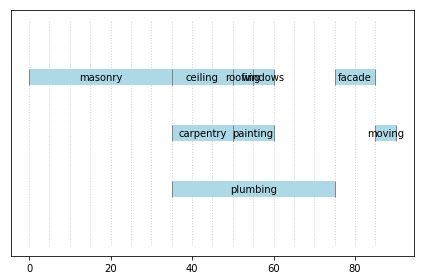

In [9]:
if msol0:
    wt = msol0.get_var_solution(masonry)   
    visu.interval(wt, 'lightblue', 'masonry')   
    wt = msol0.get_var_solution(carpentry)   
    visu.interval(wt, 'lightblue', 'carpentry')
    wt = msol0.get_var_solution(plumbing)   
    visu.interval(wt, 'lightblue', 'plumbing')
    wt = msol0.get_var_solution(ceiling)   
    visu.interval(wt, 'lightblue', 'ceiling')
    wt = msol0.get_var_solution(roofing)   
    visu.interval(wt, 'lightblue', 'roofing')
    wt = msol0.get_var_solution(painting)   
    visu.interval(wt, 'lightblue', 'painting')
    wt = msol0.get_var_solution(windows)   
    visu.interval(wt, 'lightblue', 'windows')
    wt = msol0.get_var_solution(facade)   
    visu.interval(wt, 'lightblue', 'facade')
    wt = msol0.get_var_solution(moving)   
    visu.interval(wt, 'lightblue', 'moving')
    visu.show()

##### Note on interval variables

After a time interval has been assigned a start value (say s) and an end value (say e), the interval is written as [s,e). 
The time interval does not include the endpoint e. 
If another interval variable is constrained to be placed after this interval, it can start at the time e.

# Chapter 2. Modeling and solving house building with an objective

This chapter presents the same *house building* example in such a manner that minimizes an objective.

It intends to present how to:
* use the *interval variable*,
* use the constraint *endBeforeStart*,
* use the expressions *startOf* and *endOf*.

The objective to minimize is here the cost associated with performing specific tasks before a preferred earliest start date or after a preferred latest end date. 
Some tasks must necessarily take place before other tasks, and each task has a given duration. 

To find a solution to this problem, a three-stage method is used: *describe*, *model*, and *solve*.

## Problem to be solved

The problem consists of assigning start dates to tasks in such a way that the resulting schedule satisfies precedence constraints and minimizes a criterion. 
The criterion for this problem is to minimize the earliness costs associated with starting certain tasks earlier than a given date, and tardiness costs associated with completing certain tasks later than a given date.

For each task in the house building project, the following table shows the duration (measured in days) of the task along with the tasks that must finish before the task can start.

**Note:**
The unit of time represented by an interval variable is not defined. As a result, the size of the masonry task in this problem could be 35 hours or 35 weeks or 35 months.

House construction tasks:

| Task      | Duration | Preceding tasks                   |
|-----------|----------|-----------------------------------|
| masonry   | 35       |                                   |
| carpentry | 15       | masonry                           |
| plumbing  | 40       | masonry                           |
| ceiling   | 15       | masonry                           |
| roofing   | 5        | carpentry                         |
| painting  | 10       | ceiling                           |
| windows   | 5        | roofing                           |
| facade    | 10       | roofing, plumbing                 |
| garden    | 5        | roofing, plumbing                 |
| moving    | 5        | windows, facade, garden, painting |

The other information for the problem includes the earliness and tardiness costs associated with some tasks.

House construction task earliness costs:
    
| Task      | Preferred earliest start date | Cost per day for starting early |
|-----------|-------------------------------|---------------------------------|
| masonry   | 25                            | 200.0                           |
| carpentry | 75                            | 300.0                           |
| ceiling   |75                             | 100.0                           |

House construction task tardiness costs:
    
| Task   | Preferred latest end date | Cost per day for ending late |
|--------|---------------------------|------------------------------|
| moving | 100                       | 400.0                        |

Solving the problem consists of identifying starting dates for the tasks such that the total cost, determined by the earliness and lateness costs, is minimized.

## Step 1: Describe the problem

The first step in modeling the problem is to write a natural language description of the problem, identifying the decision variables and the constraints on these variables.

Writing a natural language description of this problem requires to answer these questions:
* What is the known information in this problem ?
* What are the decision variables or unknowns in this problem ?
* What are the constraints on these variables ?
* What is the objective ?

* *What is the known information in this problem ?*

  There are ten house building tasks, each with a given duration. For each task,
there is a list of tasks that must be completed before the task can start. Some
tasks also have costs associated with an early start date or late end date.


* *What are the decision variables or unknowns in this problem ?*

  The unknowns are the date that each task will start. The cost is determined by the assigned start dates.


* *What are the constraints on these variables ?*

  In this case, each constraint specifies that a particular task may not begin until one or more given tasks have been completed.


* *What is the objective ?*

  The objective is to minimize the cost incurred through earliness and tardiness costs.

## Step 2: Declare the interval variables

In the model, each task is represented by an interval variables. 
Each variable represents the unknown information, the scheduled interval for each activity. 
After the model is executed, the values assigned to these interval variables will represent the solution to the problem.

### Declaration of engine
A scheduling model starts with the declaration of the engine as follows:

In [10]:
import sys
from docplex.cp.model import *

mdl1 = CpoModel()

The declaration of necessary interval variables is done as follows:

In [11]:
masonry = mdl1.interval_var(size=35)
carpentry = mdl1.interval_var(size=15)
plumbing = mdl1.interval_var(size=40)
ceiling = mdl1.interval_var(size=15)
roofing = mdl1.interval_var(size=5)
painting = mdl1.interval_var(size=10)
windows = mdl1.interval_var(size=5)
facade = mdl1.interval_var(size=10)
garden = mdl1.interval_var(size=5)
moving = mdl1.interval_var(size=5)

## Step 3: Add the precedence constraints

In this example, certain tasks can start only after other tasks have been completed.
*CP Optimizer* allows to express constraints involving temporal relationships between pairs of interval variables using <i>precedence constraints</i>.

Precedence constraints are used to specify when an interval variable must start or end with respect to the start or end time of another interval variable. 

The following types of precedence constraints are available; if *a* and *b* denote interval variables, both interval variables are present, and *delay* is a number or integer expression (0 by default), then:
* *end_before_end(a, b, delay)* constrains at least the given delay to elapse between the end of a and the end of b. It imposes the inequality endTime(a) + delay <= endTime(b).
* *end_before_start(a, b, delay)* constrains at least the given delay to elapse between the end of a and the start of b. It imposes the inequality endTime(a) + delay <= startTime(b).
* *end_at_end(a, b, delay)* constrains the given delay to separate the end of a and the end of ab. It imposes the equality endTime(a) + delay == endTime(b).
* *end_at_start(a, b, delay)* constrains the given delay to separate the end of a and the start of b. It imposes the equality endTime(a) + delay == startTime(b).
* *start_before_end(a, b, delay)* constrains at least the given delay to elapse between the start of a and the end of b. It imposes the inequality startTime(a) + delay <= endTime(b).
* *start_before_start(a, b, delay)* constrains at least the given delay to elapse between the start of act1 and the start of act2. It imposes the inequality startTime(a) + delay <= startTime(b).
* *start_at_end(a, b, delay)* constrains the given delay to separate the start of a and the end of b. It imposes the equality startTime(a) + delay == endTime(b).
* *start_at_start(a, b, delay)* constrains the given delay to separate the start of a and the start of b. It imposes the equality startTime(a) + delay == startTime(b).

If either interval *a* or *b* is not present in the solution, the constraint is automatically satisfied, and it is as if the constraint was never imposed.

For our model, precedence constraints can be added with the following code:

In [12]:
mdl1.add( mdl1.end_before_start(masonry, carpentry) )
mdl1.add( mdl1.end_before_start(masonry, plumbing) )
mdl1.add( mdl1.end_before_start(masonry, ceiling) )
mdl1.add( mdl1.end_before_start(carpentry, roofing) )
mdl1.add( mdl1.end_before_start(ceiling, painting) )
mdl1.add( mdl1.end_before_start(roofing, windows) )
mdl1.add( mdl1.end_before_start(roofing, facade) )
mdl1.add( mdl1.end_before_start(plumbing, facade) )
mdl1.add( mdl1.end_before_start(roofing, garden) )
mdl1.add( mdl1.end_before_start(plumbing, garden) )
mdl1.add( mdl1.end_before_start(windows, moving) )
mdl1.add( mdl1.end_before_start(facade, moving) )
mdl1.add( mdl1.end_before_start(garden, moving) )
mdl1.add( mdl1.end_before_start(painting, moving) )

To model the cost for starting a task earlier than the preferred starting date, the expression *start_of()* can be used. 
It represents the start of an interval variable as an integer expression.

For each task that has an earliest preferred start date, the number of days before the preferred date it is scheduled to start can be determined using the expression *start_of()*.
This expression can be negative if the task starts after the preferred date. 
Taking the maximum of this value and 0 using *max()* allows to determine how many days early the task is scheduled to start. 
Weighting this value with the cost per day of starting early determines the cost associated with the task.

The cost for ending a task later than the preferred date is modeled in a similar manner using the expression *endOf()*. 
The earliness and lateness costs can be summed to determine the total cost.

## Step 4: Add the objective
The objective function to be minimized can be written as follows:

In [13]:
obj = mdl1.minimize(  400 * mdl1.max([mdl1.end_of(moving) - 100, 0]) 
                    + 200 * mdl1.max([25 - mdl1.start_of(masonry), 0]) 
                    + 300 * mdl1.max([75 - mdl1.start_of(carpentry), 0]) 
                    + 100 * mdl1.max([75 - mdl1.start_of(ceiling), 0]) )
mdl1.add(obj)

Solving a problem consists of finding a value for each decision variable so that all constraints are satisfied. 
It is not always know beforehand whether there is a solution that satisfies all the constraints of the problem. 
In some cases, there may be no solution. In other cases, there may be many solutions to a problem.

## Step 5: Solve the model and display the solution

In [14]:
# Solve the model
print("\nSolving model....")
msol1 = mdl1.solve(TimeLimit=20)
print("done")


Solving model....
done


In [15]:
if msol1:
    print("Cost will be " + str(msol1.get_objective_values()[0]))
    
    var_sol = msol1.get_var_solution(masonry)
    print("Masonry : {}..{}".format(var_sol.get_start(), var_sol.get_end()))
    var_sol = msol1.get_var_solution(carpentry)
    print("Carpentry : {}..{}".format(var_sol.get_start(), var_sol.get_end()))
    var_sol = msol1.get_var_solution(plumbing)
    print("Plumbing : {}..{}".format(var_sol.get_start(), var_sol.get_end()))
    var_sol = msol1.get_var_solution(ceiling)
    print("Ceiling : {}..{}".format(var_sol.get_start(), var_sol.get_end()))
    var_sol = msol1.get_var_solution(roofing)
    print("Roofing : {}..{}".format(var_sol.get_start(), var_sol.get_end()))
    var_sol = msol1.get_var_solution(painting)
    print("Painting : {}..{}".format(var_sol.get_start(), var_sol.get_end()))
    var_sol = msol1.get_var_solution(windows)
    print("Windows : {}..{}".format(var_sol.get_start(), var_sol.get_end()))
    var_sol = msol1.get_var_solution(facade)
    print("Facade : {}..{}".format(var_sol.get_start(), var_sol.get_end()))
    var_sol = msol1.get_var_solution(moving)
    print("Moving : {}..{}".format(var_sol.get_start(), var_sol.get_end()))
else:
    print("No solution found")

Cost will be 5000
Masonry : 20..55
Carpentry : 75..90
Plumbing : 55..95
Ceiling : 75..90
Roofing : 90..95
Painting : 90..100
Windows : 95..100
Facade : 95..105
Moving : 105..110


Graphical display of the same result is available with:

In [16]:
import docplex.cp.utils_visu as visu
import matplotlib.pyplot as plt
%matplotlib inline
#Change the plot size
from pylab import rcParams
rcParams['figure.figsize'] = 15, 3

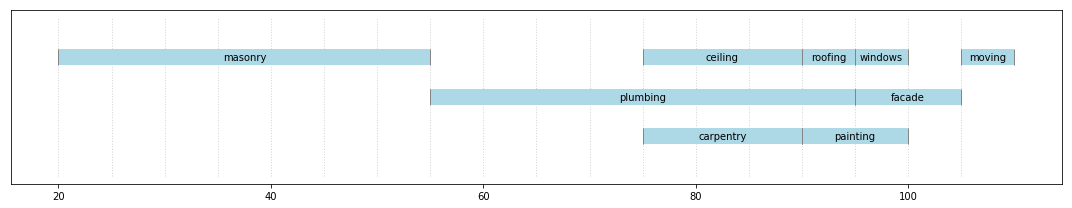

In [17]:
if msol1:
    wt = msol1.get_var_solution(masonry)   
    visu.interval(wt, 'lightblue', 'masonry')   
    wt = msol1.get_var_solution(carpentry)   
    visu.interval(wt, 'lightblue', 'carpentry')
    wt = msol1.get_var_solution(plumbing)   
    visu.interval(wt, 'lightblue', 'plumbing')
    wt = msol1.get_var_solution(ceiling)   
    visu.interval(wt, 'lightblue', 'ceiling')
    wt = msol1.get_var_solution(roofing)   
    visu.interval(wt, 'lightblue', 'roofing')
    wt = msol1.get_var_solution(painting)   
    visu.interval(wt, 'lightblue', 'painting')
    wt = msol1.get_var_solution(windows)   
    visu.interval(wt, 'lightblue', 'windows')
    wt = msol1.get_var_solution(facade)   
    visu.interval(wt, 'lightblue', 'facade')
    wt = msol1.get_var_solution(moving)   
    visu.interval(wt, 'lightblue', 'moving')
    visu.show()

The overall cost is 5000 and moving will be completed by day 110.

# Chapter 3. Adding workers and transition times to the house building problem

This chapter introduces workers and transition times to the house building problem described in the previous chapters. It allows to learn the following concepts:
* use the interval variable *sequence*;
* use the constraints *span* and *no_overlap*;
* use the expression *length_of*.

The problem to be solved is the scheduling of tasks involved in building *multiple* houses in a manner that minimizes the costs associated with completing each house after a given due date and with the length of time it takes to build each house. 
Some tasks must necessarily take place before other tasks, and each task has a predefined duration. 
Each house has an earliest starting date.
Moreover, there are two workers, each of whom must perform a given subset of the necessary tasks, and there is a transition time associated with a worker transferring from one house to another house. 
A task, once started, cannot be interrupted. 

The objective is to minimize the cost, which is composed of tardiness costs for certain tasks as well as a cost associated with the length of time it takes to complete each house. 

## Problem to be solved

The problem consists of assigning start dates to a set of tasks in such a way that the schedule satisfies temporal constraints and minimizes a criterion. 
The criterion for this problem is to minimize the tardiness costs associated with completing each house later than its specified due date and the cost associated with the length of time it takes to complete each house.

For each type of task, the following table shows the duration of the task in days along with the tasks that must be finished before the task can start. 
In addition, each type of task must be performed by a specific worker, Jim or Joe. 
A worker can only work on one task at a time. 
A task, once started, may not be interrupted. 
The time required to transfer from one house to another house is determined by a function based on the location of the two houses.

The following table indicates these details for each task:

| Task      | Duration | Worker | Preceding tasks   |
|-----------|----------|--------|-------------------|
| masonry   | 35       | Joe    |                   |
| carpentry | 15       | Joe    | masonry           |
| plumbing  | 40       | Jim    | masonry           |
| ceiling   | 15       | Jim    | masonry           |
| roofing   | 5        | Joe    | carpentry         |
| painting  | 10       | Jim    | ceiling           |
| windows   | 5        | Jim    | roofing           |
| facade    | 10       | Joe    | roofing, plumbing |
| garden    | 5        | Joe    | roofing, plumbing |
| moving    | 5        | Jim    | windows, facade,garden, painting|

For each of the five houses that must be built, there is an earliest starting date, a due date and a cost per day of completing the house later than the preferred due date.

The house construction tardiness costs is indicated in the following table:

| House | Earliest start date | Preferred latest end date | Cost per day for ending late |
|-------|---------------------|---------------------------|------------------------------|
| 0     | 0                   | 120                       | 100.0                        |
| 1     | 0                   | 212                       | 100.0                        |
| 2     | 151                 | 304                       | 100.0                        |
| 3     | 59                  | 181                       | 200.0                        |
| 4     | 243                 | 425                       | 100.0                        |

Solving the problem consists of determining starting dates for the tasks such that the cost, where the cost is determined by the lateness costs and length costs, is minimized.

## Step 1: Describe the problem

* What is the known information in this problem ?

    There are five houses to be built by two workers. For each house, there are ten house building tasks, each with a given duration, or size. Each house also has a given earliest starting date. For each task, there is a list of tasks that must be completed before the task can start. Each task must be performed by a given worker, and there is a transition time associated with a worker transferring from one house to another house. There are costs associated with completing eachhouse after its preferred due date and with the length of time it takes to complete each house.
   
   
* What are the decision variables or unknowns in this problem ?

   The unknowns are the start and end dates of the interval variables associated with the tasks. Once fixed, these interval variables also determine the cost of the solution. For some of the interval variables, there is a fixed minimum start date.


* What are the constraints on these variables ?

   There are constraints that specify a particular task may not begin until one or more given tasks have been completed. In addition, there are constraints that specify that a worker can be assigned to only one task at a time and that it takes time for a worker to travel from one house to the other.


* What is the objective ?

   The objective is to minimize the cost incurred through tardiness and length costs.

## Step2: Prepare data
First coding step is to prepare model data:

In [18]:
NbHouses = 5

WorkerNames = ["Joe", "Jim"]

TaskNames = ["masonry", "carpentry", "plumbing", 
             "ceiling", "roofing", "painting", 
             "windows", "facade", "garden", "moving"]

Duration =  [35, 15, 40, 15, 5, 10, 5, 10, 5, 5]

Worker = {"masonry"  : "Joe" , 
          "carpentry": "Joe" , 
          "plumbing" : "Jim" , 
          "ceiling"  : "Jim" , 
          "roofing"  : "Joe" , 
          "painting" : "Jim" , 
          "windows"  : "Jim" , 
          "facade"   : "Joe" , 
          "garden"   : "Joe" , 
          "moving"   : "Jim"}

ReleaseDate = [  0,     0,   151,    59,   243]
DueDate     = [120,   212,   304,   181,   425]
Weight      = [100.0, 100.0, 100.0, 200.0, 100.0]

Precedences = [("masonry", "carpentry"),("masonry", "plumbing"),
               ("masonry", "ceiling"), ("carpentry", "roofing"),
               ("ceiling", "painting"), ("roofing", "windows"),  
               ("roofing", "facade"), ("plumbing", "facade"),
               ("roofing", "garden"), ("plumbing", "garden"),
               ("windows", "moving"), ("facade", "moving"),  
               ("garden", "moving"), ("painting", "moving")]

Houses = range(NbHouses)

One part of the objective is based on the time it takes to build a house.
To model this, one interval variable is used for each house, and is later constrained to span the tasks associated with the given house. 
As each house has an earliest starting date, and each house interval variable is declared to have a start date no earlier than that release date. 
The ending date of the task is not constrained, so the upper value of the range for the variable is maxint.

## Step 3: Create the house interval variables

In [19]:
import sys
from docplex.cp.model import *

mdl2 = CpoModel()

In [20]:
houses = [mdl2.interval_var(start=(ReleaseDate[i], INTERVAL_MAX), name="house"+str(i)) for i in Houses]

## Step 4: Create the task interval variables

Each house has a list of tasks that must be scheduled. 
The duration, or size, of each task t is Duration[t]. 
This information allows to build the matrix *itvs* of interval variables.

In [21]:
TaskNames_ids = {}
itvs = {}
for h in Houses:
    for i,t in enumerate(TaskNames):
        _name = str(h)+"_"+str(t)
        itvs[(h,t)] = mdl2.interval_var(size=Duration[i], name=_name)
        TaskNames_ids[_name] = i

## Step 5: Add the precedence constraints

The tasks of the house building project have precedence constraints that are added to the model.

In [22]:
for h in Houses:
    for p in Precedences:
        mdl2.add(mdl2.end_before_start(itvs[(h,p[0])], itvs[(h,p[1])]) )

To model the cost associated with the length of time it takes to build a single house, the interval variable associated with the house is constrained to start at the start of the first task of the house and end at the end of the last task. 
This interval variable must span the tasks.


## Step 6: Add the span constraints

The constraint *span* allows to specify that one interval variable must exactly cover a set of interval variables.
In other words, the spanning interval is present in the solution if and only if at least one of the spanned interval variables is present and, in this case, the spanning interval variable starts at the start of the interval variable scheduled earliest in the set and ends at the end of the interval variable scheduled latest in the set.

For house *h*, the interval variable *houses[h]* is constrained to cover the interval variables in *itvs* that are associated with the tasks of the given house.

In [23]:
for h in Houses:
    mdl2.add( mdl2.span(houses[h], [itvs[(h,t)] for t in TaskNames] ) )

## Step 7: Create the transition times

Transition times can be modeled using tuples with three elements. 
The first element is the interval variable type of one task, the second is the interval variable type of the other task and the third element of the tuple is the transition time from the first to the second. 
An integer interval variable type can be associated with each interval variable.

Given an interval variable *a1* that precedes (not necessarily directly) an interval variable *a2* in a sequence of non-overlapping interval variables, the transition time between *a1* and *a2* is an amount of time that must elapse between the end of *a1* and the beginning of *a2*.

In [24]:
transitionTimes = transition_matrix([[int(abs(i - j)) for j in Houses] for i in Houses])

Each of the tasks requires a particular worker. 
As a worker can perform only one task at a time, it is necessary to know all of the tasks that a worker must perform and then constrain that these intervals not overlap and respect the transition times.
A sequence variable represents the order in which the workers perform the tasks.

Note that the sequence variable does not force the tasks to not overlap or the order of tasks. In a later step, a constraint is created that enforces these relations on the sequence of interval variables.

## Step 8: Create the sequence variables

Using the decision variable type sequence, variable can be created to represent a sequence of interval variables. The sequence can contain a subset of the variables or be empty. 
In a solution, the sequence will represent a total order over all the intervals in the set that are present in the solution. 
The assigned order of interval variables in the sequence does not necessarily determine their relative positions in time in the schedule. 
The sequence variable takes an array of interval variables as well as the transition types for each of those variables. 
Interval sequence variables are created for Jim and Joe, using the arrays of their tasks and the task locations.

In [25]:
workers = {w : mdl2.sequence_var([ itvs[(h,t)] for h in Houses for t in TaskNames if Worker[t]==w ], 
                                types=[h for h in Houses for t in TaskNames if Worker[t]==w ], name="workers_"+w)   
           for w in WorkerNames}

## Step 9: Add the no overlap constraint

Now that the sequence variables have been created, each sequence must be constrained such that the interval variables do not overlap in the solution, that the transition times are respected, and that the sequence represents the relations of the interval variables in time. 

The constraint *no_overlap* allows to constrain an interval sequence variable to define a chain of non-overlapping intervals that are present in the solution. 
If a set of transition tuples is specified, it defines the minimal time that must elapse between two intervals in the chain.
Note that intervals which are not present in the solution are automatically removed from the sequence.
One no overlap constraint is created for the sequence interval variable for each worker.

In [26]:
for w in WorkerNames:
    mdl2.add( mdl2.no_overlap(workers[w], transitionTimes) )

The cost for building a house is the sum of the tardiness cost and the number of days it takes from start to finish building the house. 
To model the cost associated with a task being completed later than its preferred latest end date, the expression *endOf()* can be used to determine the end date of the house interval variable. 
To model the cost of the length of time it takes to build the house, the expression *lengthOf()* can be used, which returns an expression representing the length of an interval variable. 

## Step 10: Add the objective

The objective of this problem is to minimize the cost as represented by the cost expression.

In [27]:
# create the obj and add it.
mdl2.add( 
    mdl2.minimize( 
        mdl2.sum(Weight[h] * mdl2.max([0, mdl2.end_of(houses[h])-DueDate[h]]) + mdl2.length_of(houses[h]) for h in Houses) 
    ) 
)

## Step 11: Solve the model

The search for an optimal solution in this problem can potentiality take a long time. A fail limit can be placed on the solve process to limit the search process. 
The search stops when the fail limit is reached, even if optimality of the current best solution is not guaranteed. 
The code for limiting the solve process is provided below:

In [28]:
# Solve the model
print("\nSolving model....")
msol2 = mdl2.solve(FailLimit=30000)
print("done")


Solving model....
done


In [29]:
if msol2:
    print("Cost will be " + str(msol2.get_objective_values()[0]))
else:
    print("No solution found")

Cost will be 17065


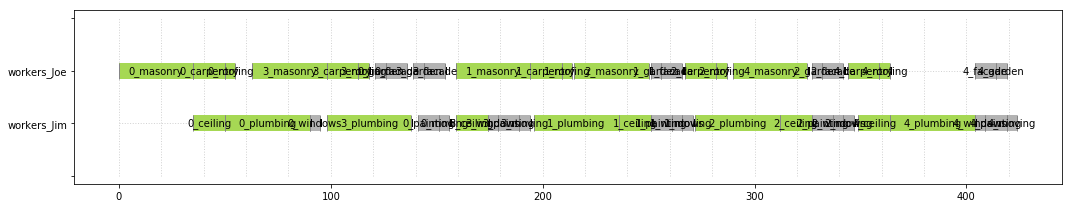

In [30]:
# Viewing the results of sequencing problems in a Gantt chart
# (double click on the gantt to see details)
import docplex.cp.utils_visu as visu
import matplotlib.pyplot as plt
%matplotlib inline
#Change the plot size
from pylab import rcParams
rcParams['figure.figsize'] = 15, 3

def showsequence(msol, s, setup, tp):
    seq = msol.get_var_solution(s)
    visu.sequence(name=s.get_name())
    vs = seq.get_value()
    for v in vs:
        nm = v.get_name()
        visu.interval(v, tp[TaskNames_ids[nm]], nm)
    for i in range(len(vs) - 1):
        end = vs[i].get_end()
        tp1 = tp[TaskNames_ids[vs[i].get_name()]]
        tp2 = tp[TaskNames_ids[vs[i + 1].get_name()]]
        visu.transition(end, end + setup.get_value(tp1, tp2))
if msol2:
    visu.timeline("Solution for SchedSetup")
    for w in WorkerNames:
        types=[h for h in Houses for t in TaskNames if Worker[t]==w]
        showsequence(msol2, workers[w], transitionTimes, types)
    visu.show()

# Chapter 4. Adding calendars to the house building problem

This chapter introduces calendars into the house building problem, a problem of scheduling the tasks involved in building multiple houses in such a manner that minimizes the overall completion date of the houses.

There are two workers, each of whom must perform a given subset of the necessary tasks. 
Each worker has a calendar detailing on which days he does not work, such as weekends and holidays. 
On a worker’s day off, he does no work on his tasks, and his tasks may not be scheduled to start or end on these days. 
Tasks that are in process by the worker are suspended during his days off.

Following concepts are demonstrated:
* use of the *step functions*,
* use an alternative version of the constraint *no_overlap*,
* use *intensity* expression,
* use the constraints *forbid_start* and *forbid_end*,
* use the *length* and *size* of an interval variable.

## Problem to be solved

The problem consists of assigning start dates to a set of tasks in such a way that the schedule satisfies temporal constraints and minimizes a criterion. 
The criterion for this problem is to minimize the overall completion date.
For each task type in the house building project, the following table shows the size of the task in days along with the tasks that must be finished before the task can start. 
In addition, each type of task can be performed by a given one of the two workers, Jim and Joe. 
A worker can only work on one task at a time. 
Once started, Problem to be solveda task may be suspended during a worker’s days off, but may not be interrupted by another task.

House construction tasks are detailed in the folowing table:

| Task      | Duration | Worker | Preceding tasks                   |
|-----------|----------|--------|-----------------------------------|
| masonry   | 35       |  Joe   |                                   |
| carpentry | 15       |  Joe   | masonry                           |
| plumbing  | 40       |  Jim   | masonry                           |
| ceiling   | 15       |  Jim   | masonry                           |
| roofing   |  5       |  Joe   | carpentry                         |
| painting  | 10       |  Jim   | ceiling                           |
| windows   |  5       |  Jim   | roofing                           |
| facade    | 10       |  Joe   | roofing, plumbing                 |
| garden    |  5       |  Joe   | roofing, plumbing                 |
| moving    |  5       |  Jim   | windows, facade, garden, painting |

Solving the problem consists of determining starting dates for the tasks such that
the overall completion date is minimized.

## Step 1: Describe the problem

The first step in modeling the problem is to write a natural language description of the problem, identifying the decision variables and the constraints on these variables.

* What is the known information in this problem ?

   There are five houses to be built by two workers. For each house, there are ten house building tasks, each with a given size. For each task, there is a list of tasks that must be completed before the task can start. Each task must be performed by a given worker, and each worker has a calendar listing his days off.


* What are the decision variables or unknowns in this problem ?

   The unknowns are the start and end times of tasks which also determine the overall completion time. The actual length of a task depends on its position in time and on the calendar of the associated worker.
   
   
* What are the constraints on these variables ?

   There are constraints that specify that a particular task may not begin until one or more given tasks have been completed. In addition, there are constraints that specify that a worker can be assigned to only one task at a time. A task cannot start or end during the associated worker’s days off.


* What is the objective ?

   The objective is to minimize the overall completion date.

## Step 2: Prepare data
A scheduling model starts with the declaration of the engine as follows:

In [31]:
import sys
from docplex.cp.model import *

mdl3 = CpoModel()

NbHouses = 5;

WorkerNames = ["Joe", "Jim" ]

TaskNames = ["masonry","carpentry","plumbing","ceiling","roofing","painting","windows","facade","garden","moving"]

Duration =  [35,15,40,15,5,10,5,10,5,5]

Worker = {"masonry":"Joe","carpentry":"Joe","plumbing":"Jim","ceiling":"Jim",
          "roofing":"Joe","painting":"Jim","windows":"Jim","facade":"Joe",
          "garden":"Joe","moving":"Jim"}


Precedences = { ("masonry","carpentry"),("masonry","plumbing"),
               ("masonry","ceiling"),("carpentry","roofing"),
               ("ceiling","painting"),("roofing","windows"),
               ("roofing","facade"),("plumbing","facade"),
               ("roofing","garden"),("plumbing","garden"),
               ("windows","moving"),("facade","moving"),  
               ("garden","moving"),("painting","moving") }

Houses = range(NbHouses)

## Step 3: Add the intensity step functions

To model the availability of a worker with respect to his days off, a step function is created to represents his intensity over time. 
This function has a range of [0..100], where the value 0 represents that the worker is not available and the value 100 represents that the worker is available with regard to his calendar.

Step functions are created by the method *step_function()*.
Each interval [x1, x2) on which the function has the same value is called a step. 
When two consecutive steps of the function have the same value, these steps are merged so that the function is always represented with the minimal number of steps.

For each worker, a sorted tupleset is created. At each point in time where the worker’s availability changes, a tuple is created. 
The tuple has two elements; the first element is an integer value that represents the worker’s availability (0 for on a break, 100 for fully available to work, 50 for a half-day), and the other element represents the date at which the availability changes to this value. 
This tupleset, sorted by date, is then used to create a step function to represent the worker’s intensity over time. 
The value of the function after the final step is set to 100.

In [32]:
Breaks ={
  "Joe" : [
     (5,14),(19,21),(26,28),(33,35),(40,42),(47,49),(54,56),(61,63),
     (68,70),(75,77),(82,84),(89,91),(96,98),(103,105),(110,112),(117,119),
     (124,133),(138,140),(145,147),(152,154),(159,161),(166,168),(173,175),
     (180,182),(187,189),(194,196),(201,203),(208,210),(215,238),(243,245),(250,252),
     (257,259),(264,266),(271,273),(278,280),(285,287),(292,294),(299,301),
     (306,308),(313,315),(320,322),(327,329),(334,336),(341,343),(348,350),
     (355,357),(362,364),(369,378),(383,385),(390,392),(397,399),(404,406),(411,413),
     (418,420),(425,427),(432,434),(439,441),(446,448),(453,455),(460,462),(467,469),
     (474,476),(481,483),(488,490),(495,504),(509,511),(516,518),(523,525),(530,532),
     (537,539),(544,546),(551,553),(558,560),(565,567),(572,574),(579,602),(607,609),
     (614,616),(621,623),(628,630),(635,637),(642,644),(649,651),(656,658),(663,665),
     (670,672),(677,679),(684,686),(691,693),(698,700),(705,707),(712,714),
     (719,721),(726,728)
  ],
  "Jim" : [
     (5,7),(12,14),(19,21),(26,42),(47,49),(54,56),(61,63),(68,70),(75,77),
     (82,84),(89,91),(96,98),(103,105),(110,112),(117,119),(124,126),(131,133),
     (138,140),(145,147),(152,154),(159,161),(166,168),(173,175),(180,182),(187,189),
     (194,196),(201,225),(229,231),(236,238),(243,245),(250,252),(257,259),
     (264,266),(271,273),(278,280),(285,287),(292,294),(299,301),(306,315),
     (320,322),(327,329),(334,336),(341,343),(348,350),(355,357),(362,364),(369,371),
     (376,378),(383,385),(390,392),(397,413),(418,420),(425,427),(432,434),(439,441),
     (446,448),(453,455),(460,462),(467,469),(474,476),(481,483),(488,490),(495,497),
     (502,504),(509,511),(516,518),(523,525),(530,532),(537,539),(544,546),
     (551,553),(558,560),(565,581),(586,588),(593,595),(600,602),(607,609),
     (614,616),(621,623),(628,630),(635,637),(642,644),(649,651),(656,658),
     (663,665),(670,672),(677,679),(684,686),(691,693),(698,700),(705,707),
     (712,714),(719,721),(726,728)]
  }

In [33]:
from collections import namedtuple
Break = namedtuple('Break', ['start', 'end'])

In [34]:
Calendar = {}
mymax = max(max(v for k,v in Breaks[w]) for w in WorkerNames)
for w in WorkerNames:
    step = CpoStepFunction()
    step.set_value(0, mymax, 100)
    for b in Breaks[w]:
        t = Break(*b)
        step.set_value(t.start, t.end, 0)
    Calendar[w] = step

This intensity function is used in creating the task variables for the workers. 
The intensity step function of the appropriate worker is passed to the creation of each interval variable. 
The size of the interval variable is the time spent at the house to process the task, not including the worker’s day off. 
The length is the difference between the start and the end of the interval.

## Step 4: Create the interval variables

In [35]:
#TaskNames_ids = {}
itvs = {}
for h in Houses:
    for i,t in enumerate(TaskNames):
        _name = str(h) + "_" + str(t)
        itvs[(h,t)] = mdl3.interval_var(size=Duration[i], intensity=Calendar[Worker[t]], name=_name)

The tasks of the house building project have precedence constraints that are added to the model.

## Step 5: Add the precedence constraints

In [36]:
for h in Houses:
    for p in Precedences:
        mdl3.add( mdl3.end_before_start(itvs[h,p[0]], itvs[h,p[1]]) )

## Step 6: Add the no overlap constraints

To add the constraints that a worker can perform only one task at a time, the interval variables associated with that worker are constrained to not overlap in the solution. 
To do this, the specialized constraint *no_overlap()* is used, but with a slightly different form than was used in the section Chapter 3, “Adding workers and transition times to the house building problem,”.

This form is a shortcut that avoids the need to explicitly define the interval sequence variable when no additional constraints are required on the sequence variable. A single *no_overlap()* constraint is added on the array of interval variables for each worker.

In [37]:
for w in WorkerNames:
    mdl3.add( mdl3.no_overlap( [itvs[h,t] for h in Houses for t in TaskNames if Worker[t]==w]  ) )

## Step 7: Create the forbidden start and end constraints

When an intensity function is set on an interval variable, the tasks which overlap weekends and/or holidays will be automatically prolonged. 
A task could still be scheduled to start or end in a weekend, but, in this problem, a worker’s tasks cannot start or end during the worker’s days off. 
*CP Optimizer* provides the constraints *forbid_start* and *forbid_end* to model these types of constraints.

With the constraint *forbid_start*, a constraint is created to specifies that an interval variable must not be scheduled to start at certain times.
The constraint takes as parameters an interval variable and a step function. 
If the interval variable is present in the solution, then it is constrained to not start at a time when the value of the step function is zero.

*CP Optimizer* also provides *forbid_end* and *forbid_extent*, which respectively constrain an interval variable to not end and not overlap where the associated step function is valued zero.
The first argument of the constraint *forbid_start* is the interval variable on which the constraint is placed.
The second argument is the step function that defines a set of forbidden values for the start of the interval variable: the interval variable cannot start at a point where the step function is 0.

In [38]:
for h in Houses:
    for t in TaskNames:
        mdl3.add(mdl3.forbid_start(itvs[h,t], Calendar[Worker[t]]))
        mdl3.add(mdl3.forbid_end (itvs[h,t], Calendar[Worker[t]]))

## Step 8: Create the objective

The objective of this problem is to minimize the overall completion date (the completion date of the house that is completed last). 
The maximum completion date among the individual house projects is determined using the expression *end_of()* on the last task in building each house (here, it is the moving task) and minimize the maximum of these expressions.

In [39]:
mdl3.add( mdl3.minimize(mdl3.max(mdl3.end_of(itvs[h,"moving"]) for h in Houses)))

## Step 9: Solve the model

The search for an optimal solution in this problem could potentiality take a long time, so a fail limit has been placed on the solve process. 
The search will stop when the fail limit is reached, even if optimality of the current best solution is not guaranteed. 
The code for limiting the solve process is provided below:

In [40]:
# Solve the model
print("\nSolving model....")
msol3 = mdl3.solve(FailLimit=30000)
print("done")


Solving model....
done


Cost will be 638


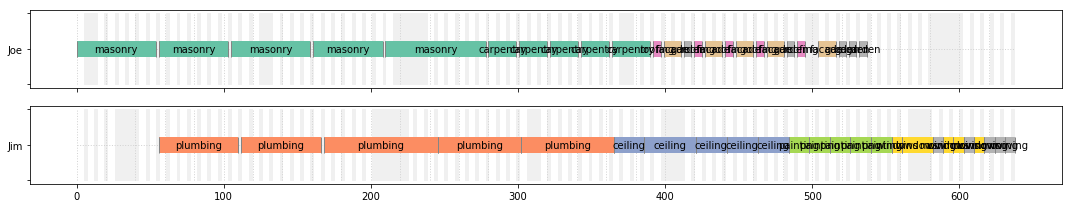

In [41]:
if msol3:
    print("Cost will be " + str( msol3.get_objective_values()[0] ))    # Allocate tasks to workers
    tasks = {w : [] for w in WorkerNames}
    for k,v in Worker.items():
        tasks[v].append(k)

    types = {t : i for i,t in enumerate(TaskNames)}

    import docplex.cp.utils_visu as visu
    import matplotlib.pyplot as plt
    %matplotlib inline
    #Change the plot size
    from pylab import rcParams
    rcParams['figure.figsize'] = 15, 3

    visu.timeline('Solution SchedCalendar')
    for w in WorkerNames:
        visu.panel()
        visu.pause(Calendar[w])
        visu.sequence(name=w,
                      intervals=[(msol3.get_var_solution(itvs[h,t]), types[t], t) for t in tasks[w] for h in Houses])
    visu.show()
else:
    print("No solution found")

# Chapter 5. Using cumulative functions in the house building problem

Some tasks must necessarily take place before other tasks, and each task has a predefined duration. 
Moreover, there are three workers, and each task requires any one of the three workers. 
A worker can be assigned to at most one task at a time. 
In addition, there is a cash budget with a starting balance. 
Each task consumes a certain amount of the budget at the start of the task, and the cash balance is increased every 60 days. 

This chapter introduces:
* use the modeling function *cumul_function*,
* use the functions *pulse*, *step*, *step_at_start* and *step_at_end*.



## Problem to be solved

The problem consists of assigning start dates to a set of tasks in such a way that the schedule satisfies temporal constraints and minimizes a criterion. The criterion
for this problem is to minimize the overall completion date. Each task requires 200 dollars per day of the task, payable at the start of the task. Every 60 days, starting
at day 0, the amount of 30,000 dollars is added to the cash balance.

For each task type in the house building project, the following table shows the duration of the task in days along with the tasks that must be finished before the task can start. Each task requires any one of the three workers. A worker can only work on one task at a time; each task, once started, may not be interrupted.

House construction tasks:

| Task      | Duration | Preceding tasks      |
|-----------|----------|----------------------|
| masonry   | 35       |                      | 
| carpentry | 15       |  masonry             | 
| plumbing  | 40       |  masonry             | 
| ceiling   | 15       |  masonry             | 
| roofingv  |  5       |  carpentry           | 
| painting  | 10       |  ceiling             | 
| windows   |  5       |  roofing             | 
| facade    | 10       |  roofing, plumbing   | 
| garden    |  5       | roofing, plumbing    | 
| moving    |  5       |  windows, facade, garden,painting | 

There is an earliest starting date for each of the five houses that must be built.

| House | Earliest starting date |
|---|----|
| 0 | 31 |
| 1 | 0  |
| 2 | 90 |
| 3 | 120|
| 4 | 90 |
Solving the problem consists of determining starting dates for the tasks such that
the overall completion date is minimized.

## Step 1: Describe the problem

The first step in modeling and solving the problem is to write a natural language description of the problem, identifying the decision variables and the constraints on these variables.

* What is the known information in this problem ?

   There are five houses to be built by three workers. For each house, there are ten house building tasks, each with a given size and cost. For each task, there is a list of tasks that must be completed before the task can start. There is a starting cash balance of a given amount, and, each sixty days, the cash balance is increased by a given amount.


* What are the decision variables or unknowns in this problem ?

   The unknown is the point in time that each task will start. Once starting dates have been fixed, the overall completion date will also be fixed.


* What are the constraints on these variables ?

   There are constraints that specify that a particular task may not begin until one or more given tasks have been completed. Each task requires any one of the three workers. In addition, there are constraints that specify that a worker can be assigned to only one task at a time. Before a task can start, the cash balance must be large enough to pay the cost of the task.


* What is the objective ?

   The objective is to minimize the overall completion date.

## Step 2: Prepare data
In the related data file, the data provided includes the number of houses (NbHouses), the number of workers (NbWorkers), the names of the tasks (TaskNames), the sizes of the tasks (Duration), the precedence relations (Precedences), and the earliest start dates of the houses (ReleaseDate).

As each house has an earliest starting date, the task interval variables are declared to have a start date no earlier than that release date of the associated house. The ending dates of the tasks are not constrained, so the upper value of the range for the variables is maxint.

In [42]:
NbWorkers = 3
NbHouses  = 5

TaskNames = {"masonry","carpentry","plumbing",
             "ceiling","roofing","painting",
             "windows","facade","garden","moving"}

Duration =  [35, 15, 40, 15, 5, 10, 5, 10, 5, 5]

ReleaseDate = [31, 0, 90, 120, 90]

Precedences = [("masonry", "carpentry"), ("masonry", "plumbing"), ("masonry", "ceiling"),
               ("carpentry", "roofing"), ("ceiling", "painting"), ("roofing", "windows"),
               ("roofing", "facade"), ("plumbing", "facade"), ("roofing", "garden"),
               ("plumbing", "garden"), ("windows", "moving"), ("facade", "moving"),
               ("garden", "moving"), ("painting", "moving")]

In [43]:
Houses = range(NbHouses)

## Step 3: Create the interval variables

In [44]:
import sys
from docplex.cp.model import *

In [45]:
mdl4 = CpoModel()

In [46]:
itvs = {}
for h in Houses:
    for i,t in enumerate(TaskNames):
        itvs[h,t] = mdl4.interval_var(start = [ReleaseDate[h], INTERVAL_MAX], size=Duration[i])

As the workers are equivalent in this problem, it is better to represent them as one pool of workers instead of as individual workers with no overlap constraints as was done in the earlier examples. 
The expression representing usage of this pool of workers can be modified by the interval variables that require a worker.

To model both the limited number of workers and the limited budget, we need to represent the sum of the individual contributions associated with the interval variables. 
In the case of the cash budget, some tasks consume some of the budget at the start. 
In the case of the workers, a task requires the worker only for the duration of the task.


## Step 4: Declare the worker usage function

A **cumulative function** expression, can be used to model a resource usage function over time. 
This function can be computed as a sum of interval variable demands on a resource over time.
An interval usually increases the cumulated resource usage function at its start time and decreases it when it releases the resource at its end time (pulse function).
For resources that can be produced and consumed by activities (for instance the contents of an inventory or a tank), the resource level can also be described as a function of time. 
A production activity will increase the resource level at the start or end time of the activity whereas a consuming activity will decrease it. 
The cumulated contribution of activities on the resource can be represented by a function of time, and constraints can be modeled on this function (for instance, a maximal or a safety level).

The value of the expression at any given moment in time is constrained to be non-negative. A cumulative function expression can be modified with the atomic demand functions:
* *step()*, which increases or decreases the level of the function by a given amount at a given time,
* *pulse()*, which increases or decreases the level of the function by a given amount for the length of a given interval variable or fixed interval,
* *step_at_start()*, which increases or decreases the level of the function by a given amount at the start of a given interval variable,
* *step_at_end()*, which increases or decreases the level of the function by a given amount at the end of a given interval variable.

A cumulative function expression can be constrained to model limited resource capacity by constraining that the function be ≤ the capacity.

Two cumulative functions are required, one to represent the usage of the workers and the other to represent the cash balance.
Each task requires one worker from the start to the end of the task interval. 

A cumulative function expression, *workerUsage* is used to represent the fact that a worker is required for the task.
This function is constrained to not exceed the number of workers at any point in time. 
The function *pulse()* adjusts the expression by a given amount on the interval. 
Summing these pulse atoms over all the interval variables results in an expression that represents worker usage over the entire time frame for building the houses.

In [47]:
workers_usage = step_at(0, 0)
for h in Houses:
    for t in TaskNames:
        workers_usage += mdl4.pulse(itvs[h,t],1)

## Step 5: Declare the cash budget function

A cumulative function *cach* is also used to model the cash budget. 
To set the initial cash balance of 30,000 dollars and increase the balance by 30,000 every sixty days, the function *step_at()* is used to increment or decrement the cumulative function expression by a fixed amount on a given date.

Each task requires a cash payment equal to 200 dollars a day for the length of the task, payable at the start of the task. 
The function *step_at_start()* is used to adjust the cash balance cumulative function expression the appropriate amount for every task.

In [48]:
cash = step_at(0, 0)
for p in Houses:
    cash += mdl4.step_at(60*p, 30000)

for h in Houses:
    for i,t in enumerate(TaskNames):
        cash -= mdl4.step_at_start(itvs[h,t], 200*Duration[i])

## Step 6: Add the temporal constraints

The tasks have precedence constraints that are added to the model.

In [49]:
for h in Houses:
    for p in Precedences:
        mdl4.add( mdl4.end_before_start(itvs[h,p[0]], itvs[h,p[1]]) )

## Step 7: Add the worker usage constraint

There is a limited number of workers, and the cumulative function expression representing worker usage must be constrained to not be greater than the number of workers..

In [50]:
mdl4.add( workers_usage <= NbWorkers )

## Step 8: Add the cash budget constraint

The budget must always be nonnegative, and the cumulative function expression representing the cash budget must be greater than 0.

In [51]:
mdl4.add( cash >= 0 )

## Step 9: Add the objective

The objective of this problem is to minimize the overall completion date (the completion date of the house that is completed last). 
The maximum completion date among the individual house projects is determined using the expression *end_of()* on the last task in building each house (here, it is the moving task) and minimize the maximum of these expressions.

In [52]:
mdl4.add(
    mdl4.minimize( 
        mdl4.max( mdl4.end_of(itvs[h,"moving"]) for h in Houses)
    )
)

## Step 10: Solve the model

The search for an optimal solution in this problem could potentiality take a long time, so a fail limit has been placed on the solve process. 
The search will stop when the fail limit is reached, even if optimality of the current best solution is not guaranteed. 
The code for limiting the solve process is:

In [53]:
# Solve the model
print("\nSolving model....")
msol4 = mdl4.solve(FailLimit=30000)
print("done")


Solving model....
done


Cost will be 285


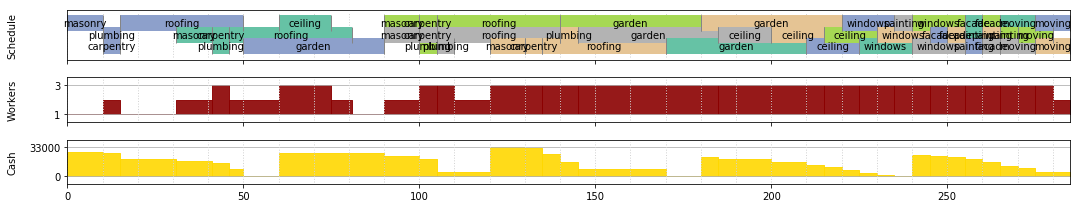

In [54]:
if msol4:
    print("Cost will be " + str( msol4.get_objective_values()[0] ))

    import docplex.cp.utils_visu as visu
    import matplotlib.pyplot as plt
    %matplotlib inline
    #Change the plot size
    from pylab import rcParams
    rcParams['figure.figsize'] = 15, 3

    workersF = CpoStepFunction()
    cashF = CpoStepFunction()
    for p in range(5):
        cashF.add_value(60 * p, INT_MAX, 30000)
    for h in Houses:
        for i,t in enumerate(TaskNames):
            itv = msol4.get_var_solution(itvs[h,t])
            workersF.add_value(itv.get_start(), itv.get_end(), 1)
            cashF.add_value(itv.start, INT_MAX, -200 * Duration[i])

    visu.timeline('Solution SchedCumul')
    visu.panel(name="Schedule")
    for h in Houses:
        for i,t in enumerate(TaskNames):
            visu.interval(msol4.get_var_solution(itvs[h,t]), h, t)
    visu.panel(name="Workers")
    visu.function(segments=workersF, style='area')
    visu.panel(name="Cash")
    visu.function(segments=cashF, style='area', color='gold')
    visu.show()
else:
    print("No solution found")

# Chapter 6. Using alternative resources in the house building problem

This chapter presents how to use alternative resources in the house building problem. The following concepts are presented:
* use the constraints *alternative* and *presence_of*,
* use the function *optional*.

Each house has a maximal completion date. 
Moreover, there are three workers, and one of the three is required for each task. 
The three workers have varying levels of skills with regard to the various tasks; if a worker has no skill for a particular task, he may not be assigned to the task. 
For some pairs of tasks, if a particular worker performs one of the pair on a house, then the same worker must be assigned to the other of the pair for that house. 
The objective is to find a solution that maximizes the task associated skill levels of the workers assigned to the tasks. 

## Problem to be solved

The problem consists of assigning start dates to a set of tasks in such a way that the schedule satisfies temporal constraints and maximizes a criterion. The criterion for this problem is to maximize the task associated skill levels of the workers assigned to the tasks.

For each task type in the house building project, the following table shows the duration of the task in days along with the tasks that must be finished before the task can start. A worker can only work on one task at a time; each task, once started, may not be interrupted.

House construction tasks:

| Task      | Duration | Preceding tasks |
|-----------|----------|-----------------|
| masonry   | 35       |                 |
| carpentry | 15       | masonry         |
| plumbing  | 40       | masonry         |
| ceiling   | 15       | masonry         |
| roofing   |  5       | carpentry       |
| painting  | 10       | ceiling         |
| windows   |  5       | roofing         |
| facade    | 10       | roofing, plumbing         |
| garden    |  5       | roofing, plumbing         |
| moving    |  5       | windows, facade, garden,painting         |

Every house must be completed within 300 days. There are three workers with varying skill levels in regard to the ten tasks. If a worker has a skill level of zero for a task, he may not be assigned to the task.

Worker-task skill levels:
    
| Task      | Joe | Jack | Jim |
|-----------|-----|------|-----|
| masonry   |  9  | 5    | 0   | 
| carpentry |  7  | 0    | 5   | 
| plumbing  |  0  | 7    | 0   | 
| ceiling   |  5  | 8    | 0   | 
| roofing   |  6  | 7    | 0   | 
| painting  |  0  | 9    | 6   | 
| windows   |  8  | 0    | 5   | 
| façade    |  5  | 5    | 0   | 
| garden    |  5  | 5    | 9   | 
| moving    |  6  | 0    | 8   | 

For Jack, if he performs the roofing task or facade task on a house, then he must perform the other task on that house. For Jim, if he performs the garden task or moving task on a house, then he must perform the other task on that house. For

Joe, if he performs the masonry task or carpentry task on a house, then he must perform the other task on that house. Also, if Joe performs the carpentry task or roofing task on a house, then he must perform the other task on that house.

## Step 1: Describe the problem
The first step in modeling and solving the problem is to write a natural language description of the problem, identifying the decision variables and the constraints on these variables.

* What is the known information in this problem ?

   There are five houses to be built by three workers. For each house, there are ten house building tasks, each with a given size. For each task, there is a list of tasks that must be completed before the task can start. Each worker has a skill level associated with each task. There is an overall deadline for the work to be completed on the five houses.


* What are the decision variables or unknowns in this problem ?

   The unknown is the point in time that each task will start. Also, unknown is which worker will be assigned to each task.


* What are the constraints on these variables ?

   There are constraints that specify that a particular task may not begin until one or more given tasks have been completed. In addition, there are constraints that specify that each task must have one worker assigned to it, that a worker can be assigned to only one task at a time and that a worker can be assigned only to tasks for which he has some level of skill. There are pairs of tasks that if one task for a house is done by a particular worker, then the other task for that house must be done by the same worker.


* What is the objective ?

   The objective is to maximize the skill levels used.

## Step 2: Prepare data
In the related data file, the data provided includes the number of houses (NbHouses), the names of the workers (Workers), the names of the tasks (Tasks), the sizes of the tasks (Durations), the precedence relations (Precedences), and the overall deadline for the construction of the houses (Deadline).

The data also includes a tupleset, Skills. Each tuple in the set consists of a worker, a task, and the skill level that the worker has for the task. In addition, there is a tupleset, Continuities, which is a set of triples (a pair of tasks and a worker). If one of the two tasks in a pair is performed by the worker for a given house, then the other task in the pair must be performed by the same worker for that house.

Two matrices of interval variables are created in this model. 
The first, tasks, is indexed on the houses and tasks and must be scheduled in the interval [0..Deadline]. 
The other matrix of interval variables is indexed on the houses and the Skills tupleset. 
These interval variables are optional and may or may not be present in the solution. 
The intervals that are performed will represent which worker performs which task.

In [55]:
NbHouses = 5
Deadline =  318

Workers = ["Joe", "Jack", "Jim"]

Tasks = ["masonry", "carpentry", "plumbing", "ceiling","roofing", "painting", "windows", "facade","garden", "moving"]

Durations =  [35, 15, 40, 15, 5, 10, 5, 10, 5, 5]

In [56]:
Skills = [("Joe","masonry",9),("Joe","carpentry",7),("Joe","ceiling",5),("Joe","roofing",6), 
          ("Joe","windows",8),("Joe","facade",5),("Joe","garden",5),("Joe","moving",6),
          ("Jack","masonry",5),("Jack","plumbing",7),("Jack","ceiling",8),("Jack","roofing",7),
          ("Jack","painting",9),("Jack","facade",5),("Jack","garden",5),("Jim","carpentry",5),
          ("Jim","painting",6),("Jim","windows",5),("Jim","garden",9),("Jim","moving",8)]

In [57]:
Precedences = [("masonry","carpentry"),("masonry","plumbing"),("masonry","ceiling"),
               ("carpentry","roofing"),("ceiling","painting"),("roofing","windows"),
               ("roofing","facade"),("plumbing","facade"),("roofing","garden"),
               ("plumbing","garden"),("windows","moving"),("facade","moving"),
               ("garden","moving"),("painting","moving")
              ]
 
Continuities = [("Joe","masonry","carpentry"),("Jack","roofing","facade"), 
                ("Joe","carpentry", "roofing"),("Jim","garden","moving")]

In [58]:
nbWorkers = len(Workers)
Houses = range(NbHouses)

## Step 3: Create the interval variables

In [59]:
import sys
from docplex.cp.model import *

In [60]:
mdl5 = CpoModel()

In [61]:
tasks = {}
wtasks = {}
for h in Houses:
    for i,t in enumerate(Tasks):
        tasks[(h,t)] = mdl5.interval_var(start=[0,Deadline], size=Durations[i])
    for s in Skills:
        wtasks[(h,s)] = mdl5.interval_var(optional=True)

## Step 4: Add the temporal constraints

The tasks in the model have precedence constraints that are added to the model.

In [62]:
for h in Houses:
    for p in Precedences:
        mdl5.add( mdl5.end_before_start(tasks[h,p[0]], tasks[h,p[1]]) )

## Step 5: Add the alternative constraints

the specialized constraint *alternative()* is used to constrain the solution so that exactly one of the interval variables tasks associated with a given task of a given house is to be present in the solution, 

The constraint *alternative()* creates a constraint between an interval and a set of intervals that specifies that if the given interval is present in the solution, then exactly one interval variable of the set is present in the solution.

In other words, consider an alternative constraint created with an interval variable *a* and an array of interval variables *bs*. If *a* is present in the solution, then exactly one of the interval variables in *bs* will be present, and *a* starts and ends together with this chosen interval.

In [63]:
for h in Houses:
    for t in Tasks:
        mdl5.add( mdl5.alternative(tasks[h,t], [wtasks[h,s] for s in Skills if s[1]==t]) )

The expression *presence_of()* is used to represent whether a task is performed by a worker. 
The constraint *presence_of()* is true if the interval variable is present in and is false if the interval variable is absent from the solution.

For each house and each given pair of tasks and worker that must have continuity, a constraint states that if the interval variable for one of the two tasks for the worker is present, the interval variable associated with that worker and the other task must also be present.

In [64]:
for h in Houses:
    for c in Continuities:
        for (worker1, task1, l1) in Skills:
            if worker1 == c[0] and task1 == c[1]:
                for (worker2, task2, l2) in Skills:
                    if worker2 == c[0] and task2 == c[2]:
                           mdl5.add(
                               mdl5.presence_of(wtasks[h,(c[0], task1, l1)]) 
                               == 
                               mdl5.presence_of(wtasks[h,(c[0], task2, l2)])
                           )

## Step 7: Add the no overlap constraints

The constraint *no_overlap()* allows to specify that a given worker can be assigned only one task at a given moment in time.

In [65]:
for w in Workers:
    mdl5.add( mdl5.no_overlap([wtasks[h,s] for h in Houses for s in Skills if s[0]==w]) )

## Step 8: Add the objective

The presence of an interval variable in the solution must be accounted in the objective. Thus for each of these possible tasks, the cost is incremented by the product of the skill level and the expression representing the presence of the interval variable in the solution.
The objective of this problem is to maximize the skill levels used for all the tasks, then to maximize the expression.

In [66]:
mdl5.add(
    mdl5.maximize(
        mdl5.sum( s[2] * mdl5.presence_of(wtasks[h,s]) for h in Houses for s in Skills)
    )
)

## Step 9: Solve the model

The search for an optimal solution in this problem could potentiality take a long time, so a fail limit has been placed on the solve process. The search will stop when the fail limit is reached, even if optimality of the current best solution is not guaranteed. 

In [67]:
# Solve the model
print("\nSolving model....")
msol5 = mdl5.solve(FailLimit=30000)
print("done")


Solving model....
done


Cost will be 360


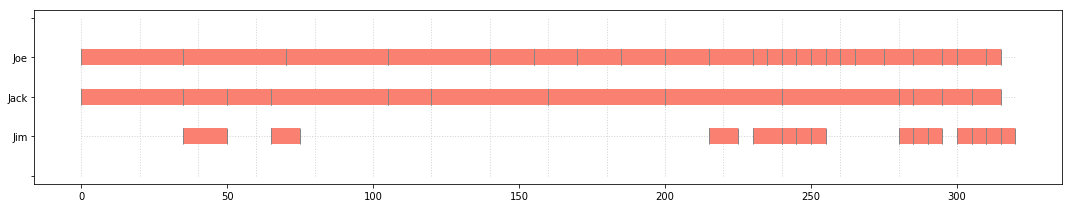

In [68]:
if msol5:
    print("Cost will be "+str( msol5.get_objective_values()[0] ))

    worker_idx = {w : i for i,w in enumerate(Workers)}
    worker_tasks = [[] for w in range(nbWorkers)]  # Tasks assigned to a given worker
    for h in Houses:
        for s in Skills:
            worker = s[0]
            wt = wtasks[(h,s)]
            worker_tasks[worker_idx[worker]].append(wt)

    import docplex.cp.utils_visu as visu
    import matplotlib.pyplot as plt
    %matplotlib inline
    #Change the plot size
    from pylab import rcParams
    rcParams['figure.figsize'] = 15, 3

    visu.timeline('Solution SchedOptional', 0, Deadline)
    for i,w in enumerate(Workers):
        visu.sequence(name=w)
        for t in worker_tasks[worker_idx[w]]:
            wt = msol5.get_var_solution(t)
            if wt.is_present():
                #if desc[t].skills[w] == max(desc[t].skills):
                    # Green-like color when task is using the most skilled worker
                #    color = 'lightgreen'
                #else:
                        # Red-like color when task does not use the most skilled worker
                #    color = 'salmon'
                color = 'salmon'
                visu.interval(wt, color, wt.get_name())
    visu.show()
else:
    print("No solution found")

# Chapter 7. Using state functions: house building with state incompatibilities

This chapter describes how to use state functions to take into account incompatible states as tasks finish. Following concepts are presented:
* use the *stateFunction*,
* use the constraint *alwaysEqual*.

There are two workers, and each task requires either one of the two workers. 
A subset of the tasks require that the house be clean, whereas other tasks make the house dirty. 
A transition time is needed to change the state of the house from dirty to clean. 

## Problem to be solved

The problem consists of assigning start dates to a set of tasks in such a way that the schedule satisfies temporal constraints and minimizes an expression. The objective for this problem is to minimize the overall completion date.

For each task type in the house building project, the following table shows the duration of the task in days along with state of the house during the task. A worker can only work on one task at a time; each task, once started, may not be interrupted.

House construction tasks:
     
| Task      | Duration | State | Preceding tasks |
|-----------|----------|-------|-----------------|
| masonry   | 35       | dirty |                 | 
| carpentry | 15       | dirty | masonry         | 
| plumbing  | 40       | clean | masonry         | 
| ceiling   | 15       | clean | masonry         | 
| roofing   | 5        | dirty | carpentry       | 
| painting  | 10       | clean | ceiling         |
| windows   | 5        | dirty | roofing         | 
| facade    | 10       |       | roofing, plumbing| 
| garden    | 5        |       | roofing, plumbing| 
| moving    | 5        |       | windows, facade,garden, painting| 

Solving the problem consists of determining starting dates for the tasks such that
the overall completion date is minimized.

## Step 1: Describe the problem

The first step in modeling and solving the problem is to write a natural language description of the problem, identifying the decision variables and the constraints on these variables.

* What is the known information in this problem ?

   There are five houses to be built by two workers. For each house, there are ten house building tasks, each with a given size. For each task, there is a list of tasks that must be completed before the task can start. There are two workers. There is a transition time associated with changing the state of a house from dirty to clean.


* What are the decision variables or unknowns in this problem ?

   The unknowns are the date that each task will start. The cost is determined by the assigned start dates.


* What are the constraints on these variables ?

   There are constraints that specify that a particular task may not begin until one or more given tasks have been completed. Each task requires either one of the two workers. Some tasks have a specified house cleanliness state.


* What is the objective ?

   The objective is to minimize the overall completion date.

## Step 2: Prepare data
In the related data, the data provided includes the number of houses (NbHouses), the number of workers (NbWorkers), the names of the tasks (TaskNames), the sizes of the tasks (Duration), the precedence relations (Precedences), and the cleanliness state of each task (AllStates).

Each house has a list of tasks that must be scheduled. The duration, or size, of each task *t* is *Duration[t]*. Using this information, a matrix task of interval variables can be built.

In [69]:
NbHouses = 5
NbWorkers = 2
AllStates = ["clean", "dirty"]

TaskNames = ["masonry","carpentry", "plumbing", "ceiling","roofing","painting","windows","facade","garden","moving"]

Duration =  [35,15,40,15,5,10,5,10,5,5]

States = [("masonry","dirty"),("carpentry","dirty"),("plumbing","clean"),
          ("ceiling","clean"),("roofing","dirty"),("painting","clean"),
          ("windows","dirty")]

Precedences = [("masonry","carpentry"),("masonry","plumbing"),("masonry","ceiling"),
               ("carpentry","roofing"),("ceiling","painting"),("roofing","windows"),
               ("roofing","facade"),("plumbing","facade"),("roofing","garden"),
               ("plumbing","garden"),("windows","moving"),("facade","moving"),
               ("garden","moving"),("painting","moving")]

In [70]:
Houses = range(NbHouses)

## Step 3: Create the interval variables

In [71]:
import sys
from docplex.cp.model import *

In [72]:
mdl6 = CpoModel()

In [73]:
task = {}
for h in Houses:
    for i,t in enumerate(TaskNames):
        task[(h,t)] = mdl6.interval_var(size = Duration[i])

## Step 4: Declare the worker usage functions

As in the example Chapter 5, “Using cumulative functions in the house building problem”, each task requires one worker from the start to the end of the task interval. To represent the fact that a worker is required for the task, a cumulative function expression *workers* is created. 
This function is constrained to not exceed the number of workers at any point in time.
he function pulse adjusts the expression by a given amount on the interval. 
Summing these pulse atoms over all the interval variables results in an expression that represents worker usage over the entire time frame for building the houses.

In [74]:
workers = step_at(0, 0)
for h in Houses:
    for t in TaskNames:
        workers += mdl6.pulse(task[h,t], 1)

## Step 5: Create the transition times

The transition time from a dirty state to a clean state is the same for all houses. 
As in the example Chapter 3, “Adding workers and transition times to the house building problem”, a tupleset *ttime* is created to represent the transition time between cleanliness states.

In [75]:
Index = {s : i for i,s in enumerate(AllStates)}

In [76]:
ttvalues = [[0, 0], [0, 0]]
ttvalues[Index["dirty"]][Index["clean"]] = 1
ttime = transition_matrix(ttvalues, name='TTime')

## Step 6: Declare the state function

Certain tasks require the house to be clean, and other tasks cause the house to be dirty. 
To model the possible states of the house, the state function *function* is used to represent the disjoint states through time.

A state function is a function describing the evolution of a given feature of the environment. 
The possible evolution of this feature is constrained by interval variables of the problem. 
For example, a scheduling problem may contain a resource whose state changes over time. 
The resource state can change because of scheduled activities or because of exogenous events; some activities in the schedule may need a particular resource state in order to execute.
Interval variables have an absolute effect on a state function, requiring the function value to be equal to a particular state or in a set of possible states.

In [77]:
state = { h : state_function(ttime, name="house"+str(h)) for h in Houses}

## Step 7: Add the constraints

To model the state required or imposed by a task, a constraint is created to specifies the state of the house throughout the interval variable representing that task.

The constraint *always_equal()*, specifies the value of a state function over the interval variable.
The constraint takes as parameters a state function, an interval variable, and a state value.
Whenever the interval variable is present, the state function is defined everywhere between the start and the end of the interval variable and remains equal to the specified state value over this interval.
The state function is constrained to take the appropriate values during the tasks that require the house to be in a specific state.
To add the constraint that there can be only two workers working at a given time, the cumulative function expression representing worker usage is constrained to not be greater than the value *NbWorkers*.

In [78]:
for h in Houses:
    for p in Precedences:
        mdl6.add( mdl6.end_before_start(task[h,p[0]], task[h,p[1]]) )

    for s in States:
        mdl6.add( mdl6.always_equal(state[h], task[h,s[0]], Index[s[1]]) )

mdl6.add( workers <= NbWorkers )

## Step 8: Add the objective

The objective of this problem is to minimize the overall completion date (the completion date of the house that is completed last).

In [79]:
mdl6.add(mdl6.minimize( mdl6.max( mdl6.end_of(task[h,"moving"]) for h in Houses )))

## Step 9: Solve the model

The search for an optimal solution in this problem could potentiality take a long time, so a fail limit has been placed on the solve process. The search will stop when the fail limit is reached, even if optimality of the current best solution is not guaranteed. 
The code for limiting the solve process is given below:

In [80]:
# Solve the model
print("\nSolving model....")
msol6 = mdl6.solve(FailLimit=30000)
print("done")


Solving model....
done


Cost will be 365


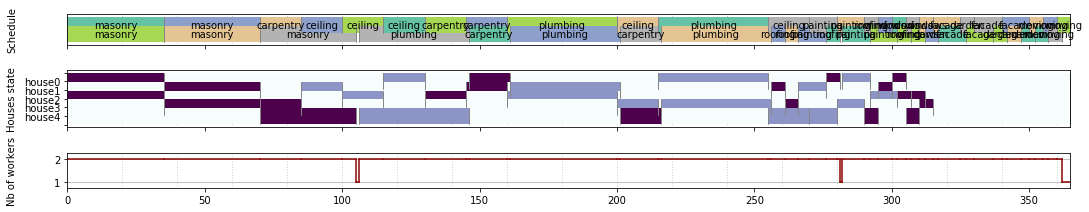

In [81]:
if msol6:
    print("Cost will be " + str( msol6.get_objective_values()[0] ))

    import docplex.cp.utils_visu as visu
    import matplotlib.pyplot as plt
    %matplotlib inline
    #Change the plot size
    from pylab import rcParams
    rcParams['figure.figsize'] = 15, 3

    workers_function = CpoStepFunction()
    for h in Houses:
        for t in TaskNames:
            itv = msol6.get_var_solution(task[h,t])
            workers_function.add_value(itv.get_start(), itv.get_end(), 1)

    visu.timeline('Solution SchedState')
    visu.panel(name="Schedule")
    for h in Houses:
        for t in TaskNames:
            visu.interval(msol6.get_var_solution(task[h,t]), h, t)


    visu.panel(name="Houses state")
    for h in Houses:
        f = state[h]
        visu.sequence(name=f.get_name(), segments=msol6.get_var_solution(f))
    visu.panel(name="Nb of workers")
    visu.function(segments=workers_function, style='line')
    visu.show()
else:
    print("No solution found")

# Summary

Having completed this notebook, the reader should be able to:
- Describe the characteristics of a Scheduling problem in terms of the objective, decision variables and constraints
- Formulate a simple Scheduling model on paper
- Conceptually explain the buidling blocks of a scheduling model
- Write a simple model with docplex


## References
* [CPLEX Modeling for Python documentation](https://rawgit.com/IBMDecisionOptimization/docplex-doc/master/docs/index.html)
* [Decision Optimization on Cloud](https://developer.ibm.com/docloud/)
* Need help with DOcplex or to report a bug? Please go [here](https://stackoverflow.com/questions/tagged/docplex).
* Contact us at dofeedback@wwpdl.vnet.ibm.com.

Copyright © 2017, 2018 IBM. IPLA licensed Sample Materials.